In [1]:
import os, sys, requests, json
import pandas as pd
import folium
from folium.plugins import FastMarkerCluster
import geopandas as gpd
import json
from ipywidgets import interact

In [2]:
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = """
[out:json];
node["amenity"="ferry_terminal"](35.0, -11.0, 71.0, 26.0);
out center;
"""


response = requests.get(overpass_url, params={'data': overpass_query})
data = response.json()
print(f"got total {len(data['elements'])} elements")

# write data to file
with open('ferry_terminals.json', 'w') as f:
    json.dump(data["elements"], f, indent=2)

got total 8433 elements


/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)
/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result =

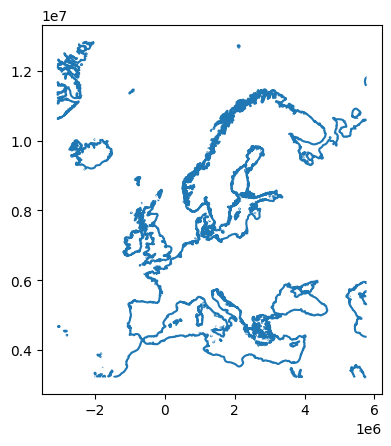

In [3]:
from shapely.geometry import Polygon
# from https://ec.europa.eu/eurostat/web/gisco/geodata/reference-data/administrative-units-statistical-units/coastal
coastlines = gpd.read_file("/Users/adipasquale/Downloads/world-coastline-simple.geojson") 
# convert polygons to lines
coastlines.geometry = coastlines.geometry.apply(lambda x: x.boundary)
bb = [-27.597656,27.839076,51.855469,74.775843]
europe_polygon = Polygon([(bb[0], bb[1]), (bb[0], bb[3]), (bb[2], bb[3]), (bb[2], bb[1])])
coastlines.geometry = coastlines.geometry.apply(lambda x: x.intersection(europe_polygon))
coastlines = coastlines[coastlines.geometry.apply(lambda x: not x.is_empty)]
coastlines.to_crs(epsg=3857, inplace=True)
coastlines.plot()

m = folium.Map(location=[51.0, -11.0], zoom_start=4)
folium.GeoJson(coastlines).add_to(m)
m

/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,type,id,lat,lon,tags,geometry
0,node,295294,58.442005,16.599294,{'amenity': 'ferry_terminal'},POINT (16.59929 58.44200)
1,node,2383584,50.706510,-1.500643,"{'addr:city': 'Yarmouth', 'addr:country': 'GB'...",POINT (-1.50064 50.70651)
2,node,5530966,59.659874,18.932094,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (18.93209 59.65987)
3,node,5530979,59.663078,18.925469,"{'amenity': 'ferry_terminal', 'name': 'Furusund'}",POINT (18.92547 59.66308)
4,node,7142214,50.375774,-4.183862,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (-4.18386 50.37577)
...,...,...,...,...,...,...
8428,node,11142512180,47.675287,9.047430,"{'addr:city': 'Mannenbach', 'addr:housenumber'...",POINT (9.04743 47.67529)
8429,node,11143855081,49.370708,16.725620,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (16.72562 49.37071)
8430,node,11148811652,53.413277,7.734257,"{'amenity': 'ferry_terminal', 'email': 'info@m...",POINT (7.73426 53.41328)
8431,node,11150206916,48.899114,18.042036,"{'amenity': 'ferry_terminal', 'cargo': 'passen...",POINT (18.04204 48.89911)


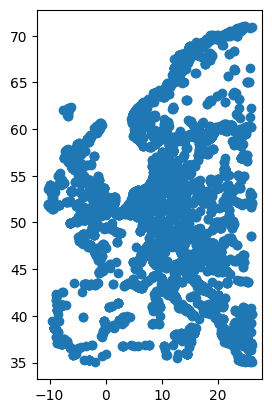

In [4]:
with open('ferry_terminals.json', 'r') as f:
    elements = json.load(f)

# create a geodataframe from the elements
df_ferry_terminals = pd.DataFrame(elements)
df_ferry_terminals = gpd.GeoDataFrame(elements, geometry=gpd.points_from_xy(df_ferry_terminals.lon, df_ferry_terminals.lat), crs="EPSG:4326")
df_ferry_terminals.plot()

m = folium.Map(location=[51.0, -11.0], zoom_start=4)
# create a fast marker cluster from the geodataframe
points_lat_lon_list = df_ferry_terminals.geometry.apply(lambda x: [x.y, x.x]).values.tolist()
FastMarkerCluster(points_lat_lon_list).add_to(m)
display(m)

df_ferry_terminals


In [5]:
df_ferry_terminals.to_crs(epsg=3857, inplace=True)
if coastlines.crs != df_ferry_terminals.crs:
    raise Exception(f"mismatching crs {coastlines.crs} != {df_ferry_terminals.crs}")

# add a column to df_ferry_terminals with the min distance to a coastline from the other dataframe
df_ferry_terminals["min_distance_to_coastline_km"] = df_ferry_terminals.geometry.apply(lambda x: round(x.distance(coastlines.geometry).min() / 1000))
df_ferry_terminals.min_distance_to_coastline_km.describe()

/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


count    8433.000000
mean      133.854500
std       203.335468
min         0.000000
25%         1.000000
50%         4.000000
75%       238.000000
max       958.000000
Name: min_distance_to_coastline_km, dtype: float64

/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


,type,id,lat,lon,tags,geometry,min_distance_to_coastline_km
0,node,295294,58.442005,16.599294,{'amenity': 'ferry_terminal'},POINT (1847825.011 8060747.753),7
1,node,2383584,50.706510,-1.500643,"{'addr:city': 'Yarmouth', 'addr:country': 'GB'...",POINT (-167050.759 6569542.075),0
2,node,5530966,59.659874,18.932094,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (2107511.041 8324398.822),0
3,node,5530979,59.663078,18.925469,"{'amenity': 'ferry_terminal', 'name': 'Furusund'}",POINT (2106773.583 8325104.922),0
4,node,7142214,50.375774,-4.183862,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (-465745.354 6511609.478),0
...,...,...,...,...,...,...,...
8423,node,11128509970,52.993180,5.753324,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (640457.098 6981736.505),46
8425,node,11135534717,54.178255,7.890183,"{'amenity': 'ferry_terminal', 'cargo': 'passen...",POINT (878331.165 7203988.162),0
8426,node,11141512068,55.253719,11.291107,"{'amenity': 'ferry_terminal', 'name': 'Skjelsk...",POINT (1256920.304 7411264.404),6
8430,node,11148811652,53.413277,7.734257,"{'amenity': 'ferry_terminal', 'email': 'info@m...",POINT (860973.595 7059811.795),39


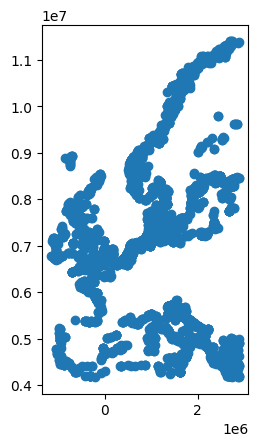

In [6]:
# filter out ferry terminals that are too far from the coast
df_ferry_terminals_seashore = df_ferry_terminals[df_ferry_terminals.min_distance_to_coastline_km < 100]
df_ferry_terminals_seashore.plot()
df_ferry_terminals_seashore.describe()

m = folium.Map(location=[51.0, -11.0], zoom_start=4)
# create a fast marker cluster from the geodataframe
points_lat_lon_list = df_ferry_terminals_seashore.to_crs(epsg=4326).geometry.apply(lambda x: [x.y, x.x]).values.tolist()
FastMarkerCluster(points_lat_lon_list).add_to(m)
display(m)

df_ferry_terminals_seashore


In [7]:
df_ferry_terminals_seashore.to_file("ferry_terminals_seashore.geojson", driver='GeoJSON')

In [8]:
df_ferry_terminals_seashore

,type,id,lat,lon,tags,geometry,min_distance_to_coastline_km
0,node,295294,58.442005,16.599294,{'amenity': 'ferry_terminal'},POINT (1847825.011 8060747.753),7
1,node,2383584,50.706510,-1.500643,"{'addr:city': 'Yarmouth', 'addr:country': 'GB'...",POINT (-167050.759 6569542.075),0
2,node,5530966,59.659874,18.932094,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (2107511.041 8324398.822),0
3,node,5530979,59.663078,18.925469,"{'amenity': 'ferry_terminal', 'name': 'Furusund'}",POINT (2106773.583 8325104.922),0
4,node,7142214,50.375774,-4.183862,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (-465745.354 6511609.478),0
...,...,...,...,...,...,...,...
8423,node,11128509970,52.993180,5.753324,"{'amenity': 'ferry_terminal', 'ferry': 'yes', ...",POINT (640457.098 6981736.505),46
8425,node,11135534717,54.178255,7.890183,"{'amenity': 'ferry_terminal', 'cargo': 'passen...",POINT (878331.165 7203988.162),0
8426,node,11141512068,55.253719,11.291107,"{'amenity': 'ferry_terminal', 'name': 'Skjelsk...",POINT (1256920.304 7411264.404),6
8430,node,11148811652,53.413277,7.734257,"{'amenity': 'ferry_terminal', 'email': 'info@m...",POINT (860973.595 7059811.795),39


In [9]:

# df_ferry_terminals_seashore["address"] = gpd.tools.reverse_geocode(df_ferry_terminals_seashore.geometry.values.tolist)
# df_ferry_terminals_seashore
# df_ferry_terminals_seashore.to_crs(epsg=4326, inplace=True)
from geopy.geocoders import GeoNames
geolocator = Photon(user_agent="greenferries", timeout=30)
gpd.tools.reverse_geocode(df_ferry_terminals_seashore.to_crs(epsg=4326).geometry.tolist()[0:10], provider="Photon")

NameError: name 'Photon' is not defined

In [65]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="greenferries", timeout=30)

from geopy.extra.rate_limiter import RateLimiter
from tqdm.notebook import tqdm

tqdm.pandas()

geolocator = Nominatim(user_agent="greenferries")
reverse_geocode = RateLimiter(geolocator.reverse, min_delay_seconds=2, error_wait_seconds=20)

# display(reverse_geocode((43.1193, 5.9311), zoom=18, addressdetails=True).raw)

cache_path = "reverse_geocode_cache.nominatim.json"
cache = {}
if os.path.exists(cache_path):
    with open(cache_path, "r") as f:
        cache = json.load(f) 

def reverse_geocode_row(row):
    cache_key = "-".join([str(row.lat), str(row.lon)])
    parsed = cache.get(cache_key)
    if parsed is None:
        raw = reverse_geocode((row.lat, row.lon), zoom=18, addressdetails=True).raw
        address = raw["address"]
        if address is None:
            raise Exception(f"no address geocoded for {row.lat}, {row.lon} : {raw}")
        city_name = address.get("municipality") or address.get("city") or address.get("town") or address.get("village") or address.get("suburb") or address.get("city_district")
        parsed = { "country_code": address.get("country_code"), "city_name": city_name, "city_postcode": address.get("postcode") }
        if parsed["country_code"] is None or parsed["city_name"] is None:
            display(raw)
            raise Exception(f"warning: missing values for {row.lat}, {row.lon}")
        cache[cache_key] = parsed
        with open(cache_path, "w") as f:
            json.dump(cache, f, indent=2)
    return pd.Series(parsed)
    
df_ferry_terminals_seashore[["country_code", "city_name", "city_postcode"]] = df_ferry_terminals_seashore.progress_apply(reverse_geocode_row, axis=1)
df_ferry_terminals_seashore.city_name.value_counts()

  0%|          | 0/5589 [00:00<?, ?it/s]

{'place_id': 269328158,
 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. http://osm.org/copyright',
 'osm_type': 'way',
 'osm_id': 413999843,
 'lat': '59.35589735',
 'lon': '-2.44127919580346',
 'class': 'man_made',
 'type': 'pier',
 'place_rank': 30,
 'importance': 9.99999999995449e-06,
 'addresstype': 'man_made',
 'name': '',
 'display_name': 'Greenspot Road, Hollandstoun, Orkney Islands, Alba / Scotland, KW17 2BE, United Kingdom',
 'address': {'road': 'Greenspot Road',
  'hamlet': 'Hollandstoun',
  'county': 'Orkney Islands',
  'ISO3166-2-lvl6': 'GB-ORK',
  'state': 'Alba / Scotland',
  'ISO3166-2-lvl4': 'GB-SCT',
  'postcode': 'KW17 2BE',
  'country': 'United Kingdom',
  'country_code': 'gb'},
 'boundingbox': ['59.3552932', '59.3563225', '-2.4417707', '-2.4408993']}

Exception: warning: missing values for 59.3552948, -2.4410211

In [49]:
# reverse geocode the ferry terminals to add 3 columns country_code, city_name and geonames_id 
# (geonames_id is the id of the city in the geonames database)
from geopy.geocoders import GeoNames
from geopy.extra.rate_limiter import RateLimiter
from tqdm.notebook import tqdm

tqdm.pandas()

geolocator = GeoNames(user_agent="greenferries-fixed", username="adipasquale")
reverse_geocode = RateLimiter(geolocator.reverse, min_delay_seconds=1, error_wait_seconds=20)

cache_path = "reverse_geocode_cache.json"
cache = {}
if os.path.exists(cache_path):
    with open(cache_path, "r") as f:
        cache = json.load(f) 

def reverse_geocode_row(row):
    cache_key = "-".join([str(row.lat), str(row.lon)])
    raw = cache.get(cache_key)
    if raw is None:
        raw = reverse_geocode((row.lat, row.lon)).raw
        cache[cache_key] = raw
        with open(cache_path, "w") as f:
            json.dump(cache, f, indent=2)
    if raw is None:
        return None, None, None
    else:
        return pd.Series([raw["countryCode"], raw["name"], raw["geonameId"]])
    
df_ferry_terminals_seashore[["country_code", "city_name", "city_geonames_id"]] = df_ferry_terminals_seashore.progress_apply(reverse_geocode_row, axis=1)
df_ferry_terminals_seashore.city_name.value_counts()

  0%|          | 0/5589 [00:00<?, ?it/s]

/Users/adipasquale/dev/greenferries/venv/lib/python3.11/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


city_name
Roman Catholic Archidiocese of Split-Makarska    28
Ladochóri                                        23
Santa Croce                                      18
Stockholm                                        15
Calais-Nord                                      14
                                                 ..
Revsneshamn                                       1
Kvalsund                                          1
Kårhamn                                           1
La Jonelière                                      1
Wiesmoor                                          1
Name: count, Length: 3174, dtype: int64

In [50]:
df_ferry_terminals_seashore.to_file("ferry_terminals_seashore.with_geonames_ids.geojson", driver='GeoJSON')